In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import lognorm
import pandas as pd
from scipy.stats import norm
import scipy.optimize as optimize
from scipy.stats.distributions import chi2
import random
import scipy.integrate as intr
import numpy.linalg as lin

#### Problem1 part(a)

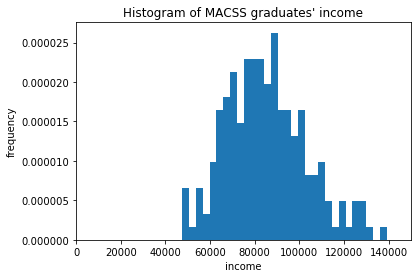

In [2]:
income = np.loadtxt("data/incomes.txt")

    
plt.hist(income, bins=30, density = True)
plt.xlim([0, 150000])
plt.xlabel("income")
plt.ylabel("frequency")
plt.title("Histogram of MACSS graduates' income")
plt.show()

#### Part(b)

In [3]:
def data_moment(val):
    
    mean_data = val.mean()
    std_data = val.std()
    
    return mean_data, std_data

In [4]:
def model_moment(mean, std, lb, ub):
    
    fx = lambda x: x * lognorm.pdf(x, s=std, scale=np.exp(mean))
    (mean_model, m_m_err) = intr.quad(fx, lb, ub)
    fx2 = lambda x: ((x - mean_model) ** 2) * lognorm.pdf(x, s=std, scale=np.exp(mean)) 
    (var_model, v_m_err) = intr.quad(fx2, lb, ub)
    
    return mean_model, var_model  ** 0.5

In [5]:
def err_vec(x, mean, std, lb, ub, simple):

    mean_data, std_data = data_moment(x)
    momt_data = np.array([mean_data, std_data])
    mean_model, std_model = model_moment(mean, std, lb, ub)
    momt_model = np.array([mean_model, std_model])
    if simple:
        err_vec = momt_model - momt_data
    else:
        err_vec = (momt_model - momt_data) / momt_data
    
    return err_vec

In [6]:
def criterion(params, *args):

    mean, std = params
    x, lb, ub, W = args
    err = err_vec(x, mean, std, lb, ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [7]:
mean_init = 11
std_init = 0.5
params_init = np.array([mean_init, std_init])
W_hat = np.eye(2)
gmm_args = (income, 0, 150000, W_hat)

results = optimize.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mean_GMM1, std_GMM1 = results.x
print('mu_GMM1=', mean_GMM1, ' sig_GMM1=', std_GMM1)
results

mu_GMM1= 11.336910355090016  sig_GMM1= 0.21302707020261594


      fun: 5.081249733090174e-16
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.27356233e-10, 4.17831083e-11])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 11
   status: 0
  success: True
        x: array([11.33691036,  0.21302707])

In [8]:
mean_data, var_data = data_moment(income)
mean_model, var_model = model_moment(mean_GMM1, std_GMM1, 0.0, 150000.0)
err = err_vec(income, mean_GMM1, std_GMM1, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Variance of points =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
print('Error vector=', err)
print("Minimized value of criterion function =", results.fun)


Mean of points = 85276.82360625811 , Variance of points = 17992.542128046523
Mean of model = 85276.82435934409 , Variance of model = 17992.541754885755
Error vector= [ 8.83107439e-09 -2.07397468e-08]
Minimized value of criterion function = 5.081249733090174e-16


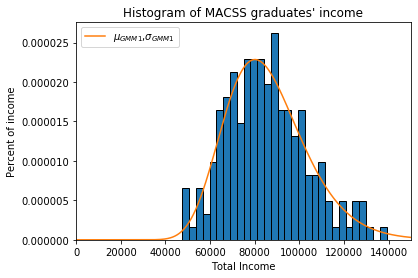

In [9]:
num_bins = 30
count, bins, ignored = plt.hist(income, num_bins, density=True,
                                edgecolor='k')
plt.title('', fontsize=20)
plt.xlabel(r'Total Income')
plt.ylabel(r'Percent of income')
plt.xlim([0, 150000]) 

# Plot the estimated GMM PDF
#dist_income = np.arange(0, 150000, 0.1)
dist_income = np.linspace(0, 150000, 10000)
plt.plot(dist_income, lognorm.pdf(dist_income, s=std_GMM1, scale=np.exp(mean_GMM1)),
         label='$\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.title("Histogram of MACSS graduates' income")
plt.legend(loc='upper left')

#### Part(c)

In [10]:
def get_Err_mat2(income, mean, std, lb, ub, simple=False):
    R = 2
    N = len(income)
    Err_mat = np.zeros((R, N))
    mean_data, std_data = data_moment(income)
    mean_model, std_model = model_moment(mean, std, lb, ub)
    if simple:
        Err_mat[0, :] = income - mean_model
        Err_mat[1, :] = abs(mean_data - income) - std_model
    else:
        Err_mat[0, :] = (income - mean_model) / mean_model
        Err_mat[1, :] = (abs(mean_data - income) - std_model) / std_model
    
    return Err_mat

In [11]:
Err_mat = get_Err_mat2(income, mean_GMM1, std_GMM1, 0.0, 150000.0, False)
VCV2 = (1 / income.shape[0]) * (Err_mat @ Err_mat.T)
W_hat2 = lin.inv(VCV2)
print(f"The weighted matrix is:\n{W_hat2}")

The weighted matrix is:
[[23.4254262  -1.57201041]
 [-1.57201041  2.56896841]]


In [12]:
gmm_args = (income, 0.0, 150000.0, W_hat2)
params_init = np.array([mean_GMM1, std_GMM1])
results2 = optimize.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mean_GMM2, std_GMM2 = results2.x
print('mu_GMM2=', mean_GMM2, ' sig_GMM2=', std_GMM2)
print("Minimized value of criterion function =", results2.fun)

mu_GMM2= 11.336910355090016  sig_GMM2= 0.21302707020261594
Minimized value of criterion function = 3.5077485891985218e-15


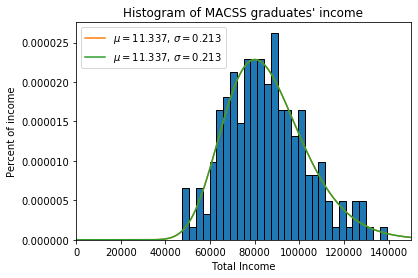

In [13]:
count, bins, ignored = plt.hist(income, num_bins, density=True,
                                edgecolor='k')
plt.title('', fontsize=20)
plt.xlabel(r'Total Income')
plt.ylabel(r'Percent of income')
plt.xlim([0, 150000]) 

# Plot the estimated GMM PDF
plt.plot(dist_income, lognorm.pdf(dist_income, s=std_GMM1, scale=np.exp(mean_GMM1)),
         label="$\mu = {:.3f}$, $\sigma = {:.3f}$". format(mean_GMM1, std_GMM1))
plt.plot(dist_income, lognorm.pdf(dist_income, s=std_GMM2, scale=np.exp(mean_GMM2)),
         label="$\mu = {:.3f}$, $\sigma = {:.3f}$". format(mean_GMM2, std_GMM2))
plt.title("Histogram of MACSS graduates' income")
plt.legend(loc='upper left')

#### Part(d)

In [14]:
def data_moments2(xvals):
   
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >= 75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

In [15]:
def model_moments2(mean, std, lb, ub):
            
    fx = lambda x: lognorm.pdf(x, s=std, scale=np.exp(mean))
    (bpct_1_mod, bp_1_err) = intr.quad(fx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intr.quad(fx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intr.quad(fx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


In [16]:
def err_vec2(xvals, mean, std, lb, ub, simple):
    

    bpct_1_dat, bpct_2_dat, bpct_3_dat= data_moments2(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments2(mean, std, lb, ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [17]:
def criterion2(params, *args):

    mean, std = params
    xvals, lb, ub, W = args
    err = err_vec2(xvals, mean, std, lb, ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [18]:
params_init = np.array([11, 0.5])
print(f"The data estimated moment is {data_moments2(income)}")
print(f"The model estimated moment is {model_moments2(mean_GMM1, std_GMM1, 0.0, 150000)}")

The data estimated moment is (0.3, 0.5, 0.2)
The model estimated moment is (0.3000727037411666, 0.49559813870050745, 0.20115866580096034)


In [19]:
W_hat1 = np.eye(3)
gmm_args = (income, 0.0, 150000.0, W_hat1)
results3 = optimize.minimize(criterion2, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_2, sig_GMM1_2 = results3.x
print('mu_GMM1_4=', mu_GMM1_2, ' sig_GMM1_4=', sig_GMM1_2)
print(f"The minimum value of criterion function is {results3.fun}")

mu_GMM1_4= 11.33672664190664  sig_GMM1_4= 0.21174641946015713
The minimum value of criterion function is [[2.38181733e-05]]


Text(0.5, 1.0, "Histogram of MACSS graduates' income")

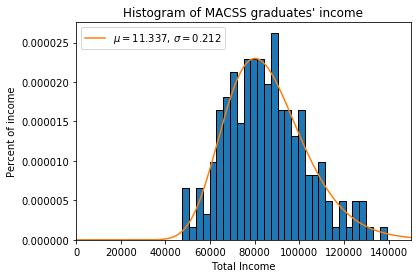

In [20]:

count, bins, ignored = plt.hist(income, num_bins, density=True,
                                edgecolor='k')
plt.title('', fontsize=20)
plt.xlabel(r'Total Income')
plt.ylabel(r'Percent of income')
plt.xlim([0, 150000]) 

# Plot the estimated GMM PDF
plt.plot(dist_income, lognorm.pdf(dist_income, s=sig_GMM1_2, scale=np.exp(mu_GMM1_2)),
         label="$\mu = {:.3f}$, $\sigma = {:.3f}$". format(mu_GMM1_2, sig_GMM1_2))

plt.legend(loc='upper left')
plt.title("Histogram of MACSS graduates' income")

#### Part(e)

In [21]:
def get_Err_mat2(income, mean, std, lb, ub, simple=False):

    R = 3
    N = len(income)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = model_moments2(mean, std, lb, ub)
    if simple:
        pts_in_grp1 = income < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (income >= 75000) & (income < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = income >= 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod
    else:
        pts_in_grp1 = income < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (income >= 75000) & (income < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = income >= 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [22]:
Err_mat2 = get_Err_mat2(income, mu_GMM1_2, sig_GMM1_2, 0.0, 1500000.0, True)
VCV2_2 = (1 / income.shape[0]) * (Err_mat2 @ Err_mat2.T)
# We use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2_2 = lin.pinv(VCV2_2)
print(f"The weighted matrix of four moments GMM model is \n{W_hat2_2}")

The weighted matrix of four moments GMM model is 
[[110574.59551465 110570.77671129 110571.50792032]
 [110570.77671129 110572.29124126 110571.02245029]
 [110571.50792032 110571.02245029 110576.75365932]]


In [23]:
params_init = np.array([mu_GMM1_2, sig_GMM1_2])
gmm_args = (income, 0.0, 1500000.0, W_hat2_2)
results4 = optimize.minimize(criterion2, params_init, args=(gmm_args),
                          method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2_2, sig_GMM2_2 = results4.x
print('mu_GMM2_4=', mu_GMM2_2, ' sig_GMM2_4=', sig_GMM2_2)
print(f"The minimum value of criterion function is {results4.fun}")
results4

mu_GMM2_4= 11.336512011579739  sig_GMM2_4= 0.2139202443964036
The minimum value of criterion function is [[0.00068264]]


      fun: array([[0.00068264]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.02027067, 0.04992602])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 78
      nit: 16
   status: 0
  success: True
        x: array([11.33651201,  0.21392024])

Text(0.5, 1.0, "Histogram of MACSS graduates' income")

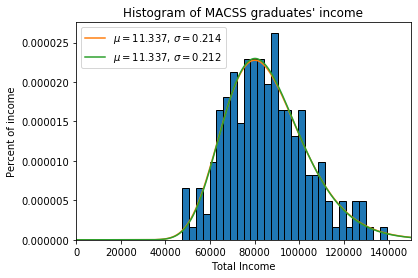

In [24]:
count, bins, ignored = plt.hist(income, num_bins, density=True,
                                edgecolor='k')
plt.title('', fontsize=20)
plt.xlabel(r'Total Income')
plt.ylabel(r'Percent of income')
plt.xlim([0, 150000]) 

# Plot the estimated GMM PDF
plt.plot(dist_income, lognorm.pdf(dist_income, s=sig_GMM2_2, scale=np.exp(mu_GMM2_2)),
         label="$\mu = {:.3f}$, $\sigma = {:.3f}$". format(mu_GMM2_2, sig_GMM2_2))
plt.plot(dist_income, lognorm.pdf(dist_income, s=sig_GMM1_2, scale=np.exp(mu_GMM1_2)),
         label="$\mu = {:.3f}$, $\sigma = {:.3f}$". format(mu_GMM1_2, sig_GMM1_2))

plt.legend(loc='upper left')
plt.title("Histogram of MACSS graduates' income")

In [25]:
mean = [mean_GMM1, mean_GMM2, mu_GMM1_2, mu_GMM2_2]
std = [std_GMM1, std_GMM2, sig_GMM1_2, sig_GMM2_2]
criter = [results.fun, results2.fun, results3.fun, results4.fun]
for i in range(4):
    print(f"The mean of the model {i + 1} is {mean[i]}, the standard deviation of {std[i]}, the criteria function value is {[criter[i]]}.")

The mean of the model 1 is 11.336910355090016, the standard deviation of 0.21302707020261594, the criteria function value is [5.081249733090174e-16].
The mean of the model 2 is 11.336910355090016, the standard deviation of 0.21302707020261594, the criteria function value is [3.5077485891985218e-15].
The mean of the model 3 is 11.33672664190664, the standard deviation of 0.21174641946015713, the criteria function value is [array([[2.38181733e-05]])].
The mean of the model 4 is 11.336512011579739, the standard deviation of 0.2139202443964036, the criteria function value is [array([[0.00068264]])].


##### From the observation, we can see  that the outcome of four GMM models are close to each other. The estimations are compelling because it describes the data well. With a careful look at the standard deviation of the estimators and the criteria function, the mean-variance minimization GMM seems to capture the data better. The criteria function of both one-step and two-step models are close and one step seems to do better

#### Problem 2

In [26]:
df=pd.read_csv("data/sick.txt")
def err(df ,b0, b1, b2, b3):
    y_model = b0 + b1 * df['age'] + b2 * df['children'] + b3 * df['avgtemp_winter']
    y_data = df['sick']
    err = y_model - y_data
    return err

In [27]:
def criterion(params, *args):
    b0, b1, b2, b3 = params
    df, W = args
    error = err(df, b0, b1, b2, b3)
    crit_val = error.T @ W @ error
    return crit_val

In [28]:
params_init = np.array([1, 0, 0, 0])
w_hat = np.eye(len(df))
gmm_args = (df, w_hat)
result0 = optimize.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,method='L-BFGS-B')
result0

      fun: 0.001821289806039237
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.71889412e-07, -1.94165430e-06, -5.87951996e-06, -5.54422827e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 135
      nit: 11
   status: 0
  success: True
        x: array([ 0.25164486,  0.01293347,  0.40050098, -0.00999171])

In [29]:
b0_GMM, b1_GMM, b2_GMM, b3_GMM = result0.x
print('GMM estimates for parameters are:')
print(f'b0 = {b0_GMM}\nb1 = {b1_GMM}\nb2 = {b2_GMM}\nb3 = {b3_GMM}.') 
print(f"Criterion function value = {result0.fun}")

GMM estimates for parameters are:
b0 = 0.2516448640150513
b1 = 0.012933471011867557
b2 = 0.40050098412750457
b3 = -0.009991709739756627.
Criterion function value = 0.001821289806039237
